In [34]:
import os
import glob
import pathlib

import matplotlib.pyplot as plt  
import numpy as np
import pandas as pd
import scipy.misc
import seaborn as sns  
import tensorflow as tf 
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split

from tensorflow.keras import layers  
from tensorflow.keras import models  

In [2]:
tf.__version__

'2.7.0'

In [3]:
seed = 123
tf.random.set_seed(seed)
np.random.seed(seed)

In [35]:
DATA_PATH = '../data/spcup_2022_training_part1'
IMAGE_PATH = '../data/images'
Labeled_dir = '../data/spcup_2022_training_part1/labels.csv'

In [5]:
label_df = pd.read_csv(Labeled_dir)
label_df.head()

,track,algorithm
0,00050dd7458cf08e594c797930696bce.wav,4
1,00070e7c531000d3dddc735d107275a9.wav,2
2,000f0711027a69b7f3886c2dbcb7d41f.wav,3
3,001e28e66dee24408aaf3480dfb95fbe.wav,1
4,001eee950f60613869544b72cd48fe97.wav,2


In [6]:
X, y = label_df['track'].values, label_df['algorithm'].values

In [7]:
X_train = tf.convert_to_tensor(X)
y_train = tf.convert_to_tensor(y)

In [8]:
primary_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))

In [9]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [30]:
def get_waveform_and_label(file_path):
  # label = get_label(file_path)
  cpath = DATA_PATH + os.sep + file_path
  audio_binary = tf.io.read_file(cpath)
  waveform = decode_audio(audio_binary)
  return (waveform, file_path)

In [31]:
AUTOTUNE = tf.data.AUTOTUNE
waveform_ds = primary_ds.map(
    # map_func=lambda x: tf.py_function(func=get_waveform_and_label, inp=[x], Tout=(tf.float32, tf.int64)),
    # map_func=lambda x,y: (tf.py_function(get_waveform_and_label, [x], tf.float32), y),
    map_func=lambda x,y: (get_waveform_and_label(x), y),
    num_parallel_calls=AUTOTUNE)

waveform_ds = waveform_ds.map(map_func=lambda x,y: (x[0], x[1], y), num_parallel_calls=AUTOTUNE)

In [32]:
waveform_ds.element_spec

(TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

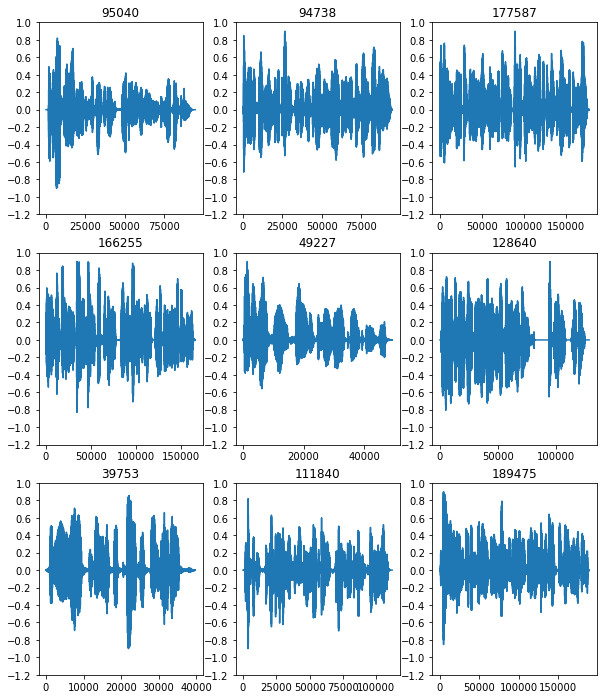

In [28]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, name, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
#   label = label.numpy()
#   ax.set_title(tf.strings.split(name).numpy()[0].decode().split('\\')[-1])
  ax.set_title(len(audio.numpy()))

plt.show()

mel-spectrogram [link](https://www.tensorflow.org/io/tutorials/audio)

In [33]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 236280
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [input_len] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [42]:
def save_spectrogram(spect, name):
  spectrogram = spect.numpy()
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  save_path = IMAGE_PATH+os.sep+name
  scipy.misc.imsave(save_path, log_spec)
  return (spectrogram, name)
  
  # height = log_spec.shape[0]
  # width = log_spec.shape[1]
  # X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  # Y = range(height)
  # ax.pcolormesh(X, Y, log_spec)

In [37]:
spectrogram_ds = waveform_ds.map(
  map_func=lambda x,y,z: (get_spectrogram(x),y,z),
  num_parallel_calls=AUTOTUNE)

In [44]:
spectrogram_ds.element_spec

(TensorSpec(shape=(None, 129, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [43]:
spectrogram_ds = spectrogram_ds.map(
  map_func=lambda x,y,z: (tf.py_function(save_spectrogram(x,y)),z),
  num_parallel_calls=AUTOTUNE)

AttributeError: in user code:

    File "C:\Users\deela\AppData\Local\Temp/ipykernel_23044/429594203.py", line 2, in None  *
        lambda x,y,z: (tf.py_function(save_spectrogram(x,y)),z)
    File "C:\Users\deela\AppData\Local\Temp/ipykernel_23044/315807301.py", line 2, in save_spectrogram  *
        spectrogram = spect.numpy()

    AttributeError: 'Tensor' object has no attribute 'numpy'
